In [ ]:
import os
import pickle 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path = os.path.join("..", "obj", "ner_final.pkl")
with open(path, "rb") as f:
    df = pickle.load(f)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution(df, column_name, output_file):
    plt.figure(figsize=(8, 5))
    plot = sns.countplot(data=df, x=column_name, order=df[column_name].value_counts().index, palette='viridis')
    plt.title(f'Distribution of {column_name} labels')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Annotate counts on the bars
    for p in plot.patches:
        plot.annotate(format(p.get_height(), '.0f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='center', 
                      xytext=(0, 9), 
                      textcoords='offset points')
    
    plt.tight_layout()
    #plt.savefig(output_file)
    plt.show()

_distribution(df, 'Main AU', 'main_au_distribution.png')

NameError: name '_distribution' is not defined

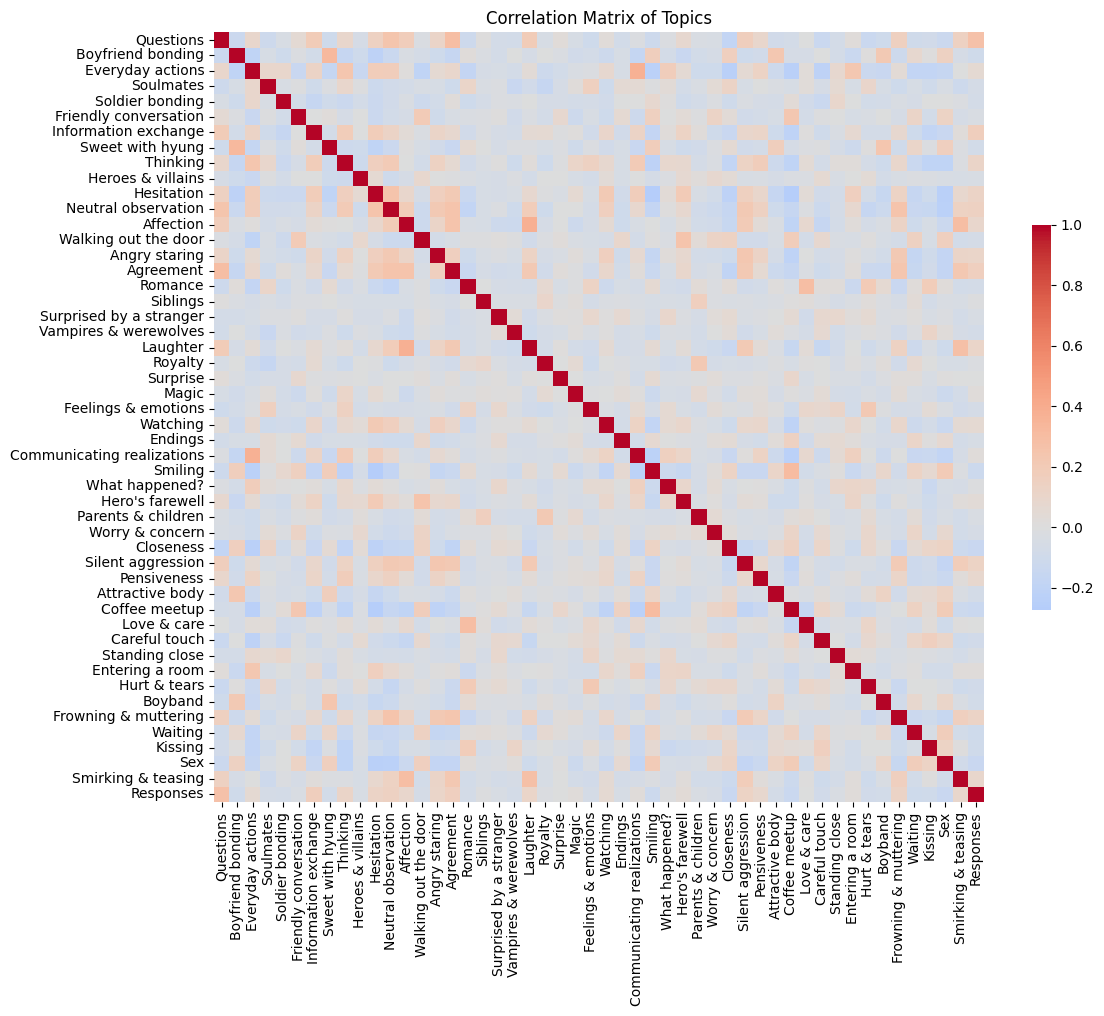

In [ ]:
# Extract only topic columns
topic_data = df.iloc[:, 1:51]

plt.figure(figsize=(12, 10))
corr = topic_data.corr()
sns.heatmap(corr, cmap='coolwarm', center=0, square=True, cbar_kws={'shrink': .5})
plt.title('Correlation Matrix of Topics')
plt.tight_layout()
plt.show()

# some covariance - use models that can handle it!

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

# Features and target
X = df.iloc[:, 1:51]
y = df['Main fandom']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split (stratify to preserve AU distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [ ]:

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)


DummyClassifier(strategy='most_frequent')

In [22]:
from sklearn.linear_model import LogisticRegression

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga'],
    'multi_class': ['multinomial'],
    'class_weight': ['balanced']
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='f1_macro', n_jobs=-1)
grid_lr.fit(X_train, y_train)

print("Best Logistic Regression:", grid_lr.best_params_)
print(classification_report(y_test, grid_lr.predict(X_test), target_names=label_encoder.classes_))


/home/ucloud/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' 

Best Logistic Regression: {'C': 10, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga'}
              precision    recall  f1-score   support

  coffeeshop       0.66      0.90      0.76       969
     royalty       0.83      0.89      0.86       869
   soulmates       0.95      0.78      0.85      2407
     vampire       0.83      0.84      0.83       729

    accuracy                           0.83      4974
   macro avg       0.81      0.85      0.83      4974
weighted avg       0.85      0.83      0.83      4974



In [12]:
with open('fandom_best_lr_model.pkl', 'wb') as f:
    pickle.dump(grid_lr.best_estimator_, f)

In [23]:
with open('au_best_lr_model.pkl', 'wb') as f:
    pickle.dump(grid_lr.best_estimator_, f)

In [13]:
with open('fandom_best_lr_model.pkl', "rb") as f:
    fandom_lr = pickle.load(f)

In [24]:
with open('au_best_lr_model.pkl', "rb") as f:
    au_lr = pickle.load(f)

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from tqdm.auto import tqdm
from joblib import parallel
import joblib

# --- Progress bar wrapper for joblib ---
class TqdmJoblib:
    def __init__(self, tqdm_object):
        self.tqdm = tqdm_object

    def __enter__(self):
        self.original_callback = joblib.parallel.BatchCompletionCallBack

        def new_callback(*args, **kwargs):
            self.tqdm.update()
            return self.original_callback(*args, **kwargs)

        joblib.parallel.BatchCompletionCallBack = new_callback

    def __exit__(self, exc_type, exc_val, exc_tb):
        joblib.parallel.BatchCompletionCallBack = self.original_callback

param_grid_rf = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [5, 10, 20, 50],
    'min_samples_split': [5, 10, 20],
    'class_weight': ['balanced'],
    'max_features': [0.6, 0.8, 1],
}

# Total jobs = param combos × folds
from sklearn.model_selection import ParameterGrid
n_total = len(ParameterGrid(param_grid_rf)) * 5  # 5-fold CV

# --- GridSearchCV with tqdm ---
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
)

with tqdm(total=n_total, desc="GridSearchCV Progress") as progress_bar:
    with TqdmJoblib(progress_bar):
        grid_rf.fit(X_train, y_train)

# --- Results ---
print("Best Random Forest:", grid_rf.best_params_)
print(classification_report(y_test, grid_rf.predict(X_test), target_names=label_encoder.classes_))

GridSearchCV Progress:   0%|          | 0/720 [00:00<?, ?it/s]

Best Random Forest: {'class_weight': 'balanced', 'max_depth': 50, 'max_features': 0.6, 'min_samples_split': 5, 'n_estimators': 500}
              precision    recall  f1-score   support

        bnha       0.90      0.89      0.89      1188
         bts       0.96      0.91      0.94      1663
          hp       0.85      0.82      0.84       840
         mcu       0.81      0.89      0.85      1283

    accuracy                           0.89      4974
   macro avg       0.88      0.88      0.88      4974
weighted avg       0.89      0.89      0.89      4974



In [9]:

with open('fandom_best_random_forest_model.pkl', 'wb') as f:
    pickle.dump(grid_rf.best_estimator_, f)

In [5]:
with open('fandom_best_random_forest_model.pkl', "rb") as f:
    fandom_rf = pickle.load(f)

In [25]:
with open('au_best_random_forest_model.pkl', "rb") as f:
    au_rf = pickle.load(f)

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from tqdm.auto import tqdm
from joblib import parallel
import joblib
import xgboost as xgb

# --- Progress bar wrapper for joblib ---
class TqdmJoblib:
    def __init__(self, tqdm_object):
        self.tqdm = tqdm_object

    def __enter__(self):
        self.original_callback = joblib.parallel.BatchCompletionCallBack

        def new_callback(*args, **kwargs):
            self.tqdm.update()
            return self.original_callback(*args, **kwargs)

        joblib.parallel.BatchCompletionCallBack = new_callback

    def __exit__(self, exc_type, exc_val, exc_tb):
        joblib.parallel.BatchCompletionCallBack = self.original_callback

# --- XGBoost param grid ---
param_grid_xgb = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth' : [5, 10, 20, 50],
    'colsample_bytree': [0.6, 0.8, 1],
    'learning_rate': [2e-3, 2e-2, 2e-1],
    'subsample': [0.6, 0.8, 1.0]
}

# --- Total grid runs × CV folds ---
n_total = len(ParameterGrid(param_grid_xgb)) * 5  # 3-fold CV

# --- GridSearchCV with tqdm ---
grid_xgb = GridSearchCV(
    xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=4,
        eval_metric='mlogloss',
        random_state=42
    ),
    param_grid=param_grid_xgb,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
)

with tqdm(total=n_total, desc="XGBoost GridSearchCV Progress") as progress_bar:
    with TqdmJoblib(progress_bar):
        grid_xgb.fit(X_train, y_train)

# --- Results ---
print("Best XGBoost:", grid_xgb.best_params_)
print(classification_report(y_test, grid_xgb.predict(X_test), target_names=label_encoder.classes_))


XGBoost GridSearchCV Progress:   0%|          | 0/2160 [00:00<?, ?it/s]

/home/ucloud/.local/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best XGBoost: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 20, 'n_estimators': 500, 'subsample': 0.6}
              precision    recall  f1-score   support

        bnha       0.92      0.91      0.92      1188
         bts       0.95      0.94      0.95      1663
          hp       0.87      0.87      0.87       840
         mcu       0.87      0.89      0.88      1283

    accuracy                           0.91      4974
   macro avg       0.90      0.90      0.90      4974
weighted avg       0.91      0.91      0.91      4974



In [14]:

with open('fandom_best_xgboost_model.pkl', 'wb') as f:
    pickle.dump(grid_xgb.best_estimator_, f)

In [27]:
with open('fandom_best_xgboost_model.pkl', "rb") as f:
    fandom_xgb = pickle.load(f)

In [26]:
with open('au_best_xgboost_model.pkl', "rb") as f:
    au_xgb = pickle.load(f)

In [7]:
f1_scores = {}

In [9]:
f1_scores['Dummy'] = {
    'Fandom': classification_report(y_test, dummy_clf.predict(X_test), output_dict=True)['macro avg']['f1-score']
}

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
f1_scores['Logistic Regression'] = {
    'Fandom': classification_report(y_test, fandom_lr.predict(X_test), output_dict=True)['macro avg']['f1-score']
}

In [17]:
f1_scores['Random Forest'] = {
    'Fandom': classification_report(y_test, fandom_rf.predict(X_test), output_dict=True)['macro avg']['f1-score']
}

In [18]:
f1_scores['XGBoost'] = {
    'Fandom': classification_report(y_test, fandom_xgb.predict(X_test), output_dict=True)['macro avg']['f1-score']
}

In [27]:
f1_scores['Dummy'] = {
    'AU': classification_report(y_test, dummy_clf.predict(X_test), output_dict=True)['macro avg']['f1-score']
}
f1_scores['Logistic Regression'] = {
    'AU': classification_report(y_test, au_lr.predict(X_test), output_dict=True)['macro avg']['f1-score']
}
f1_scores['Random Forest'] = {
    'AU': classification_report(y_test, au_rf.predict(X_test), output_dict=True)['macro avg']['f1-score']
}
f1_scores['XGBoost'] = {
    'AU': classification_report(y_test, au_xgb.predict(X_test), output_dict=True)['macro avg']['f1-score']
}

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
f1_au_dummy = classification_report(y_test, dummy_clf.predict(X_test), output_dict=True)['macro avg']['f1-score']
f1_au_lr = classification_report(y_test, au_lr.predict(X_test), output_dict=True)['macro avg']['f1-score']
f1_au_rf = classification_report(y_test, au_rf.predict(X_test), output_dict=True)['macro avg']['f1-score']
f1_au_xgb = classification_report(y_test, au_xgb.predict(X_test), output_dict=True)['macro avg']['f1-score']
f1_au = [f1_au_dummy, f1_au_lr, f1_au_rf, f1_au_xgb]
f1_au

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[0.1630537867497629,
 0.8258206438457245,
 0.8768135932841596,
 0.8856995018161635]

In [33]:
f1_fandom_dummy = classification_report(y_test, dummy_clf.predict(X_test), output_dict=True)['macro avg']['f1-score']
f1_fandom_lr = classification_report(y_test, fandom_lr.predict(X_test), output_dict=True)['macro avg']['f1-score']
f1_fandom_rf = classification_report(y_test, fandom_rf.predict(X_test), output_dict=True)['macro avg']['f1-score']
f1_fandom_xgb = classification_report(y_test, fandom_xgb.predict(X_test), output_dict=True)['macro avg']['f1-score']
f1_fandom = [f1_fandom_dummy, f1_fandom_lr, f1_fandom_rf, f1_fandom_xgb]
f1_fandom

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[0.12528250715684797,
 0.8362104368349517,
 0.8786475228776343,
 0.9026849322825918]

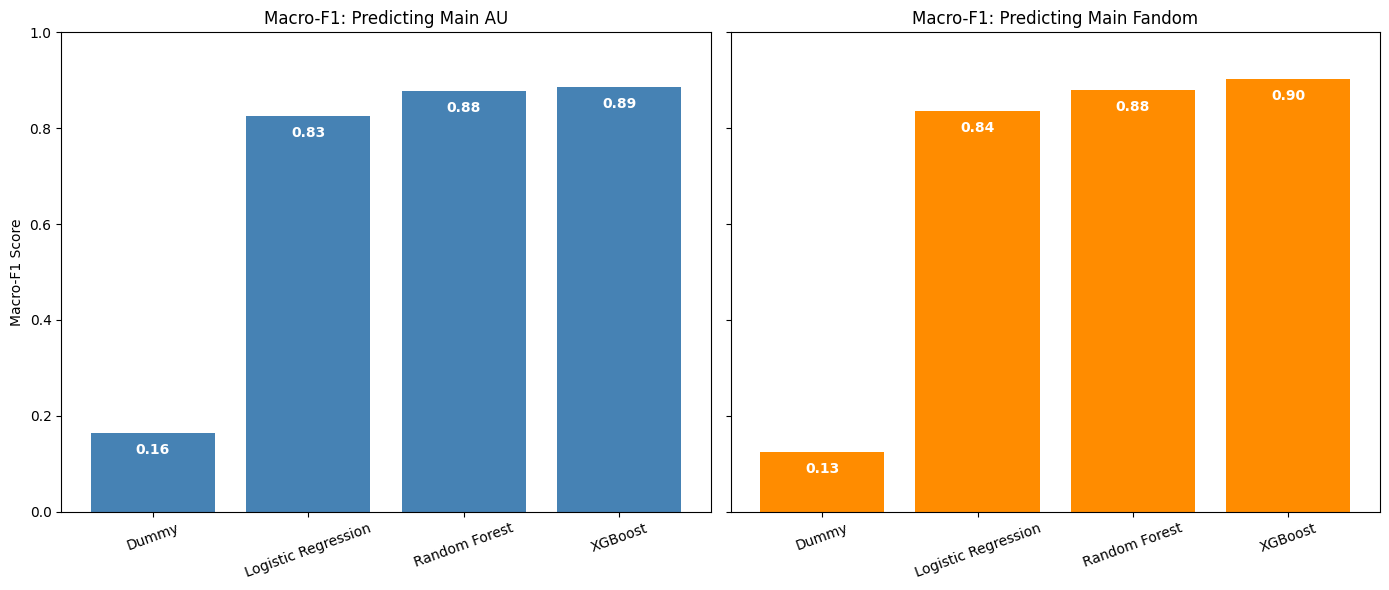

In [36]:
# Example data — replace with your actual F1 scores
model_names = ['Dummy', 'Logistic Regression', 'Random Forest', 'XGBoost']

# Set up the plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Plot for Main AU ---
bars_au = axes[0].bar(model_names, f1_au, color='steelblue')
axes[0].set_title('Macro-F1: Predicting Main AU')
axes[0].set_ylabel('Macro-F1 Score')
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='x', rotation=20)

# Add labels on bars
for bar in bars_au:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, height - 0.05, f"{height:.2f}",
                 ha='center', va='bottom', color='white', fontsize=10, fontweight='bold')

# --- Plot for Main Fandom ---
bars_fandom = axes[1].bar(model_names, f1_fandom, color='darkorange')
axes[1].set_title('Macro-F1: Predicting Main Fandom')
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='x', rotation=20)

# Add labels on bars
for bar in bars_fandom:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height - 0.05, f"{height:.2f}",
                 ha='center', va='bottom', color='white', fontsize=10, fontweight='bold')

# Layout
plt.tight_layout()
plt.savefig("models_f1.png")
plt.show()

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Use TreeExplainer for tree-based models (Random Forest, XGBoost)
explainer = shap.TreeExplainer(fandom_rf)  # or xgb_model
shap_values = explainer.shap_values(X_test)

for i, class_name in tqdm(enumerate(fandom_rf.classes_), desc="Calculating SHAP values", total=len(fandom_rf.classes_)):
    # Calculate mean absolute SHAP values for each feature for the current class
    mean_shap_values = np.abs(shap_values[i]).mean(axis=0)

    # Get the top 10 features by mean SHAP value
    top_10_idx = np.argsort(mean_shap_values)[-10:]
    top_10_features = np.array(feature_names)[top_10_idx]
    top_10_shap_values = mean_shap_values[top_10_idx]
    print(f"Top features for class {class_name}:")
    for name, value in zip(top_10_features, top_10_shap_values):
        print(f"{name}: {value:.5f}")

    # Plot the top 10 features for the current class
    plt.figure(figsize=(10, 6))
    plt.barh(top_10_features, top_10_shap_values, color='steelblue')
    plt.title(f"Top 10 Features for Class: {class_name} (Mean Absolute SHAP)")
    plt.xlabel("Mean Absolute SHAP Value")
    plt.gca().invert_yaxis()  # Highest at the top
    plt.tight_layout()
    plt.show()

    # Save the mean_shap_values for this class to a pickle file
    with open(f'fandom_rf_shap_{class_name}.pkl', 'wb') as f:
        pickle.dump(mean_shap_values, f)


In [9]:
feature_names = X_test.columns

In [10]:
feature_names

Index(['Questions', 'Boyfriend bonding', 'Everyday actions', 'Soulmates',
       'Soldier bonding', 'Friendly conversation', 'Information exchange',
       'Sweet with hyung', 'Thinking', 'Heroes & villains', 'Hesitation',
       'Neutral observation', 'Affection', 'Walking out the door',
       'Angry staring', 'Agreement', 'Romance', 'Siblings',
       'Surprised by a stranger', 'Vampires & werewolves', 'Laughter',
       'Royalty', 'Surprise', 'Magic', 'Feelings & emotions', 'Watching',
       'Endings', 'Communicating realizations', 'Smiling', 'What happened?',
       'Hero's farewell', 'Parents & children', 'Worry & concern', 'Closeness',
       'Silent aggression', 'Pensiveness', 'Attractive body', 'Coffee meetup',
       'Love & care', 'Careful touch', 'Standing close', 'Entering a room',
       'Hurt & tears', 'Boyband', 'Frowning & muttering', 'Waiting', 'Kissing',
       'Sex', 'Smirking & teasing', 'Responses'],
      dtype='object')

In [14]:
with open('fandom_rf_shap_0.pkl', "rb") as f:
    shap0 = pickle.load(f)

In [17]:
shap_values.shape

(4974, 50, 4)

In [19]:
shap_values[0].shape

(50, 4)

In [22]:
shap_values[i].mean(axis=1).shape

(50,)

Plotting SHAP per class:   0%|          | 0/4 [00:00<?, ?it/s]

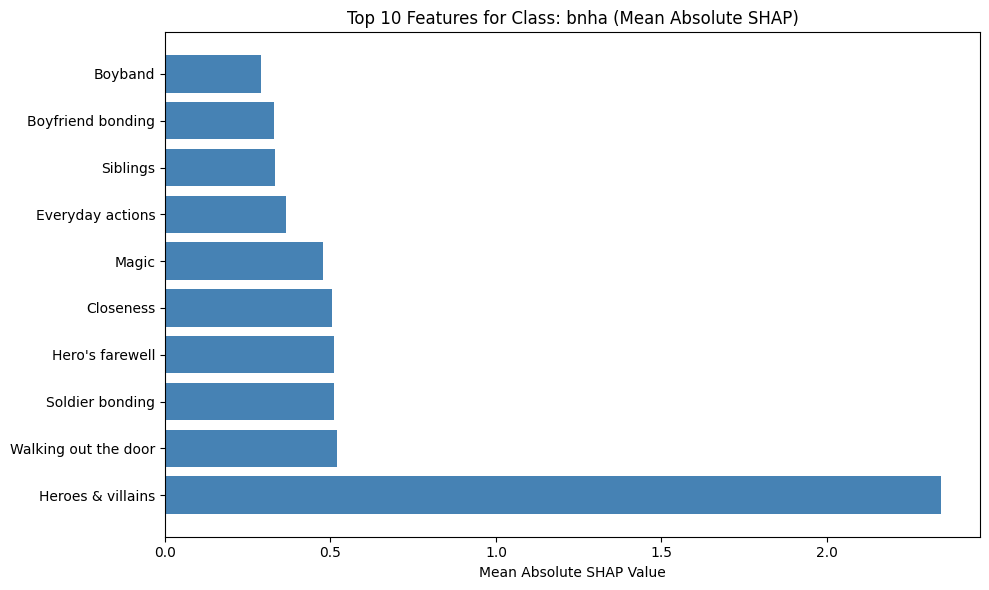

Plotting SHAP per class:  25%|██▌       | 1/4 [00:00<00:01,  2.95it/s]

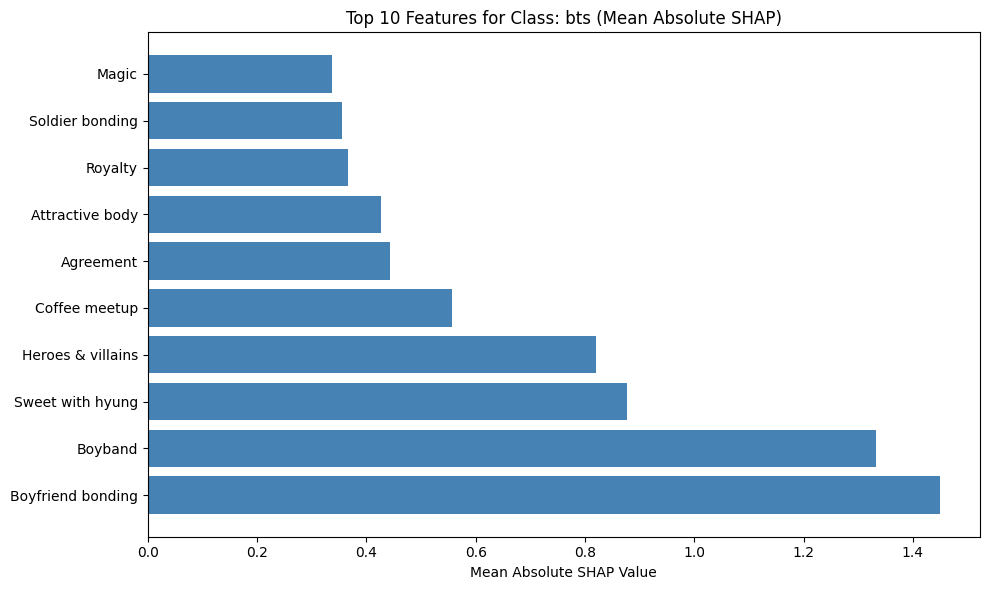

Plotting SHAP per class:  50%|█████     | 2/4 [00:00<00:00,  4.77it/s]

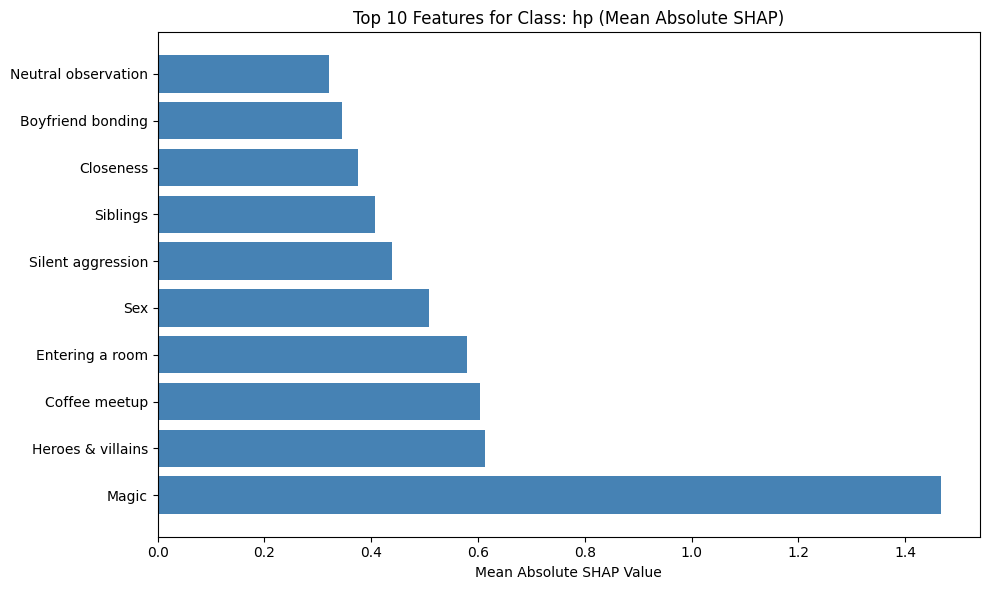

Plotting SHAP per class:  75%|███████▌  | 3/4 [00:00<00:00,  5.95it/s]

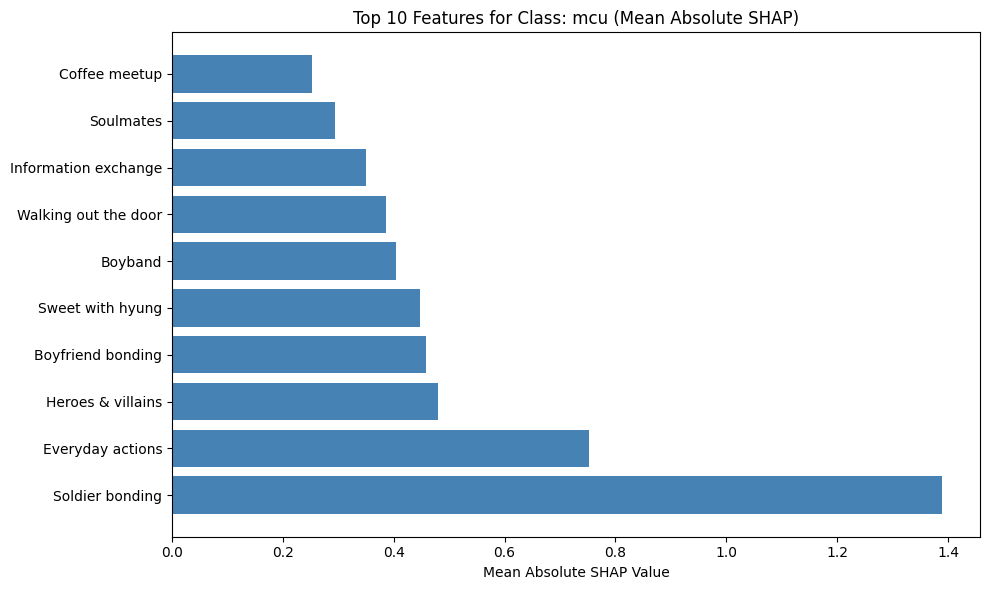

Plotting SHAP per class: 100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


In [ ]:
class_names = label_encoder.classes_

for i in tqdm(range(len(class_names)), desc="Plotting SHAP per class"):
    class_i_shap_values = shap_values[:, :, i]
    mean_shap_values = np.abs(class_i_shap_values).mean(axis=0)

    top_10_idx = np.argsort(mean_shap_values)[-10:]
    top_10_features = np.array(feature_names)[top_10_idx]
    top_10_shap_values = mean_shap_values[top_10_idx]

    plt.figure(figsize=(10, 6))
    plt.barh(top_10_features, top_10_shap_values, color='steelblue')
    plt.title(f"Top 10 Features for Class: {class_names[i]} (Mean Absolute SHAP)")
    plt.xlabel("Mean Absolute SHAP Value")
    plt.tight_layout()
    plt.show()


In [30]:
with open('fandom_xgb.pkl', 'wb') as f:
    pickle.dump(shap_values, f)

In [28]:
explainer = shap.TreeExplainer(fandom_xgb)  # or xgb_model
shap_values = explainer.shap_values(X_test)